In [1]:
using JLD2, CairoMakie
using Jchemo, JchemoData
using Loess

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/tecator.jld2")
@load db dat
pnames(dat)

(:X, :Y)

In [3]:
X = dat.X
Y = dat.Y
ntot = nro(X)

178

In [4]:
@head X

... (178, 100)
 


Row,850,852,854,856,858,860,862,864,866,868,870,872,874,876,878,880,882,884,886,888,890,892,894,896,898,900,902,904,906,908,910,912,914,916,918,920,922,924,926,928,930,932,934,936,938,940,942,944,946,948,950,952,954,956,958,960,962,964,966,968,970,972,974,976,978,980,982,984,986,988,990,992,994,996,998,1000,1002,1004,1006,1008,1010,1012,1014,1016,1018,1020,1022,1024,1026,1028,1030,1032,1034,1036,1038,1040,1042,1044,1046,1048
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,2.62964,2.63245,2.63565,2.63933,2.64353,2.64825,2.6535,2.65937,2.66585,2.67281,2.68008,2.68733,2.69427,2.70073,2.70684,2.71281,2.71914,2.72628,2.73462,2.74416,2.75466,2.76568,2.77679,2.7879,2.79949,2.81225,2.82706,2.84356,2.86106,2.87857,2.89497,2.90924,2.92085,2.93015,2.93846,2.94771,2.96019,2.97831,3.00306,3.03506,3.07428,3.11963,3.16868,3.21771,3.26254,3.29988,3.32847,3.34899,3.36342,3.37379,3.38152,3.38741,3.39164,3.39418,3.3949,3.39366,3.39045,3.38541,3.37869,3.37041,3.36073,3.34979,3.33769,3.32443,3.31013,3.29487,3.27891,3.26232,3.24542,3.22828,3.2108,3.19287,3.17433,3.15503,3.13475,3.11339,3.09116,3.0685,3.04596,3.02393,3.00247,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.8596,2.8394,2.8192
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.8606,2.86566,2.87093,2.87661,2.88264,2.88898,2.89577,2.90308,2.91097,2.91953,2.92873,2.93863,2.94929,2.96072,2.97272,2.98493,2.9969,3.00833,3.0192,3.0299,3.04101,3.05345,3.06777,3.08416,3.10221,3.12106,3.13983,3.1581,3.17623,3.19519,3.21584,3.23747,3.25889,3.27835,3.29384,3.30362,3.30681,3.30393,3.297,3.28925,3.28409,3.28505,3.29326,3.30923,3.33267,3.36251,3.39661,3.43188,3.46492,3.49295,3.51458,3.53004,3.54067,3.54797,3.55306,3.55675,3.55921,3.56045,3.56034,3.55876,3.55571,3.55132,3.54585,3.5395,3.53235,3.52442,3.51583,3.50668,3.497,3.48683,3.47626,3.46552,3.45501,3.44481,3.43477,3.42465,3.41419,3.40303,3.39082,3.37731,3.36265,3.34745,3.33245,3.31818,3.30473,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.196,3.17942
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,2.60414,2.60714,2.61029,2.61361,2.61714,2.62089,2.62486,2.62909,2.63361,2.63835,2.6433,2.64838,2.65354,2.6587,2.66375,2.6688,2.67383,2.67892,2.68411,2.68937,2.6947,2.70012,2.70563,2.71141,2.71775,2.7249,2.73344,2.74327,2.75433,2.76642,2.77931,2.79272,2.80649,2.82064,2.83541,2.85121,2.86872,2.88905,2.91289,2.94088,2.97325,3.00946,3.0478,3.08554,3.11947,3.14696,3.16677,3.17938,3.18631,3.18924,3.1895,3.18801,3.18498,3.18039,3.17411,3.16611,3.15641,3.14512,3.13241,3.11843,3.10329,3.08714,3.07014,3.05237,3.03393,3.01504,2.99569,2.97612,2.95642,2.9366,2.91667,2.89655,2.87622,2.85563,2.83474,2.81361,2.79235,2.77113,2.75015,2.72956,2.70934,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816


In [5]:
@head Y

... (178, 4)
 


Row,water,fat,protein,typ
,Float64,Float64,Float64,String
1,60.5,22.5,16.7,train
2,46.0,40.1,13.5,train
3,71.0,8.4,20.5,train


In [6]:
summ(Y)

(res = 4×7 DataFrame
 Row │ variable  mean    std     min   max   n      nmissing 
     │ Symbol    Union…  Union…  Any   Any   Int64  Int64    
─────┼───────────────────────────────────────────────────────
   1 │ water     63.046  9.784   39.3  76.6    178         0
   2 │ fat       18.378  12.629  0.9   49.1    178         0
   3 │ protein   17.634  2.996   11.0  21.8    178         0
   4 │ typ                       test  val     178         0, ntot = 178)

In [7]:
namy = names(Y)[1:3]

3-element Vector{String}:
 "water"
 "fat"
 "protein"

In [8]:
typ = Y.typ
tab(typ)

OrderedCollections.OrderedDict{String, Int64} with 3 entries:
  "test"  => 31
  "train" => 115
  "val"   => 32

In [9]:
wl = names(X)
wl_num = parse.(Float64, wl)

100-element Vector{Float64}:
  850.0
  852.0
  854.0
  856.0
  858.0
  860.0
  862.0
  864.0
  866.0
  868.0
    ⋮
 1032.0
 1034.0
 1036.0
 1038.0
 1040.0
 1042.0
 1044.0
 1046.0
 1048.0

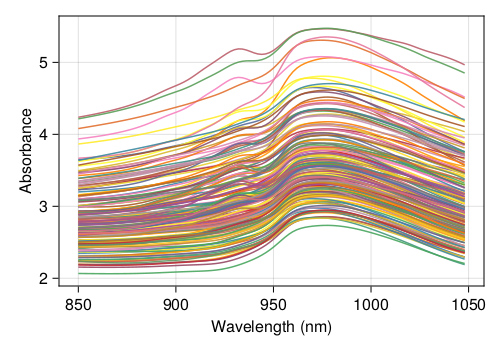

In [10]:
plotsp(X, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

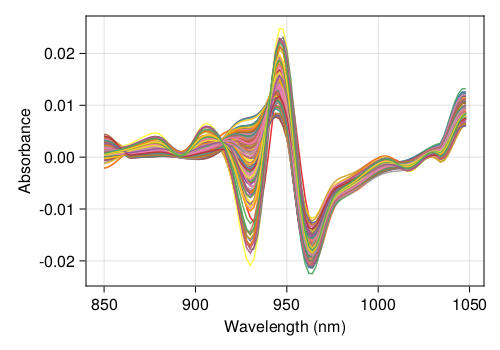

In [11]:
# Preprocessing
f = 15 ; pol = 3 ; d = 2
Xp = savgol(snv(X); f = f, pol = pol, d = d)

plotsp(Xp, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

In [12]:
# Split Tot = Train + Test
# The model is tuned on Train, and
# the generalization error is estimated on Test.
# Here the split of Tot is provided by the dataset
# (= variable 'typ'), but Tot could be split
# a posteriori (e.g. random sampling, systematic
# sampling, etc.)
s = typ .== "train"
Xtrain = Xp[s, :]
Ytrain = Y[s, namy]
Xtest = rmrow(Xp, s)
Ytest = rmrow(Y[:, namy], s)
ntrain = nro(Xtrain)
ntest = nro(Xtest)
ntot = ntrain + ntest
(ntot = ntot, ntrain, ntest)

(ntot = 178, ntrain = 115, ntest = 63)

In [13]:
# Work on the second y-variable
j = 2
nam = namy[j]    # y-variable
ytrain = Ytrain[:, nam]
ytest = Ytest[:, nam]

63-element Vector{Float64}:
 29.8
  1.4
  4.6
 11.0
 17.0
 22.4
 27.9
 46.5
  6.1
  2.0
  ⋮
 18.1
 19.4
 24.8
 27.2
 28.4
 31.3
 33.8
 35.5
 42.5

In [14]:
# The cross-validation (CV) is done within Train,
# and the generalization error is estimated on Test.
# Two methods can be used to build the
# segments within Train:
# (1) Replicated K-fold CV
# ==> Train is splitted in a number of K folds (segments)
# ==> and the process can be replicated
K = 3     # nb. folds (segments)
rep = 10  # nb. replications
segm = segmkf(ntrain, K; rep = rep)
# (2) Or replicated "Test-set" CV
# ==> splitting Train = Cal + Val
# ==> and the process can be replicated
# e.g. Cal = 70% of Train, Val = 30% of Train
#pct = .30
#m = round(pct * ntrain)
#segm = segmts(ntrain, m; rep = 30)

10-element Vector{Any}:
 [[1, 2, 3, 4, 5, 6, 7, 10, 13, 17  …  86, 88, 89, 92, 94, 101, 103, 105, 110, 111], [8, 11, 14, 16, 18, 20, 22, 23, 24, 26  …  90, 95, 97, 99, 102, 104, 106, 108, 109, 114], [9, 12, 15, 19, 21, 27, 28, 31, 42, 43  …  87, 91, 93, 96, 98, 100, 107, 112, 113, 115]]
 [[2, 3, 6, 12, 13, 15, 16, 20, 25, 30  …  84, 85, 88, 93, 94, 103, 104, 105, 106, 115], [5, 7, 9, 11, 17, 18, 19, 21, 23, 24  …  87, 91, 95, 96, 98, 107, 111, 112, 113, 114], [1, 4, 8, 10, 14, 22, 27, 28, 29, 32  …  90, 92, 97, 99, 100, 101, 102, 108, 109, 110]]
 [[1, 6, 8, 9, 10, 14, 20, 25, 28, 29  …  88, 89, 92, 94, 95, 102, 103, 106, 107, 115], [5, 7, 11, 15, 18, 21, 23, 24, 26, 30  …  82, 86, 96, 97, 98, 100, 101, 104, 108, 109], [2, 3, 4, 12, 13, 16, 17, 19, 22, 27  …  90, 91, 93, 99, 105, 110, 111, 112, 113, 114]]
 [[5, 9, 11, 13, 15, 17, 18, 22, 26, 28  …  88, 89, 91, 97, 101, 103, 104, 105, 111, 115], [8, 10, 19, 21, 23, 29, 36, 37, 40, 42  …  79, 86, 90, 92, 94, 95, 96, 106, 107, 114], [1, 2,

In [15]:
i = 1
k = 1
segm[i]      # the K segments of replication 'i'

3-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 10, 13, 17  …  86, 88, 89, 92, 94, 101, 103, 105, 110, 111]
 [8, 11, 14, 16, 18, 20, 22, 23, 24, 26  …  90, 95, 97, 99, 102, 104, 106, 108, 109, 114]
 [9, 12, 15, 19, 21, 27, 28, 31, 42, 43  …  87, 91, 93, 96, 98, 100, 107, 112, 113, 115]

In [16]:
segm[i][k]   # segment 'k' of replication 'i'

39-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
  10
  13
  17
   ⋮
  88
  89
  92
  94
 101
 103
 105
 110
 111

In [17]:
# Model tuning
nlv = 0:20
rescv = gridcvlv(Xtrain, ytrain; segm = segm,
    score = rmsep, fun = plskern, nlv = nlv,
    verbose = false) ;
pnames(rescv)

(:res, :res_rep)

In [18]:
# Variability of the performance
# between segments (folds) and replications
res_rep = rescv.res_rep

Row,repl,segm,nlv,y1
,Int64,Int64,Int64,Float64
1,1,1,0,14.0122
2,1,1,1,2.12516
3,1,1,2,2.02273
4,1,1,3,2.32251
5,1,1,4,2.6074
6,1,1,5,2.09557
7,1,1,6,2.06404
8,1,1,7,2.13897
9,1,1,8,2.17035


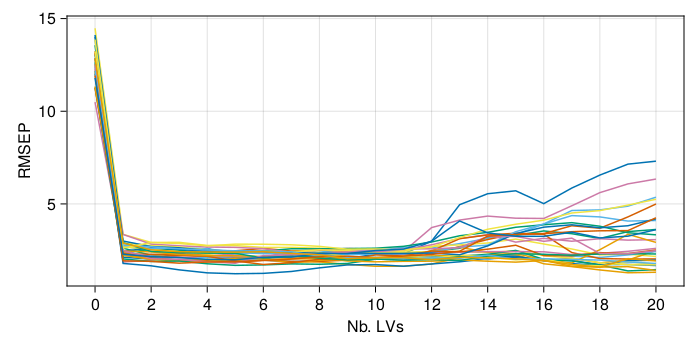

In [19]:
group = string.(res_rep.segm, "-", res_rep.repl)
plotgrid(res_rep.nlv, res_rep.y1, group; step = 2,
    xlabel = "Nb. LVs", ylabel = "RMSEP", leg = false).f

In [20]:
# Average results over the segments (folds)
# and the replications
res = rescv.res

Row,nlv,y1
,Int64,Float64
1,0,12.6419
2,1,2.49466
3,2,2.32479
4,3,2.28676
5,4,2.23311
6,5,2.19856
7,6,2.21115
8,7,2.19827
9,8,2.22239


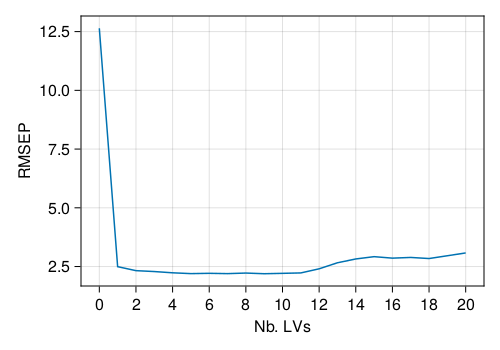

In [21]:
plotgrid(res.nlv, res.y1; step = 2,
    xlabel = "Nb. LVs", ylabel = "RMSEP").f

Find the minimal prediction error

In [22]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,nlv,y1
,Int64,Float64
10,9,2.19391


In [23]:
# Final prediction (Test) using the optimal model
fm = plskern(Xtrain, ytrain; nlv = res.nlv[u]) ;
pred = Jchemo.predict(fm, Xtest).pred

63×1 Matrix{Float64}:
 28.03515255932761
  2.5700025992963704
  4.380809734134999
  9.747260563885781
 13.983507225400686
 21.867950356441604
 25.565026045461515
 50.76730418769364
  9.403211168255968
  3.080366635683564
  ⋮
 16.42154219323392
 17.860572390693623
 20.073294239685286
 27.972077822716205
 25.608205321057053
 33.86530007787934
 32.98240040121496
 37.62487294492132
 46.210740963973265

In [24]:
# Generalization error
rmsep(pred, ytest)

1×1 Matrix{Float64}:
 1.8712902096014785

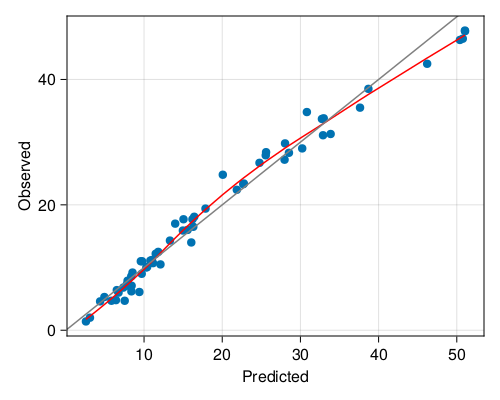

In [25]:
# Plotting predictions vs. observed data
zpred = vec(pred)
f, ax = plotxy(zpred, ytest;
    xlabel = "Predicted", ylabel = "Observed",
    resolution = (500, 400))
zfm = loess(zpred, ytest; span = 2/3) ;
pred_loess = Loess.predict(zfm, sort(zpred))
lines!(ax, sort(zpred), pred_loess; color = :red)
ablines!(ax, 0, 1; color = :grey)
f

In [26]:
# A parcimony approach
# Wold's criterion
res_sel = selwold(res.nlv, res.y1; smooth = false,
    alpha = .05, graph = true) ;
pnames(res)

2-element Vector{Symbol}:
 :nlv
 :y1

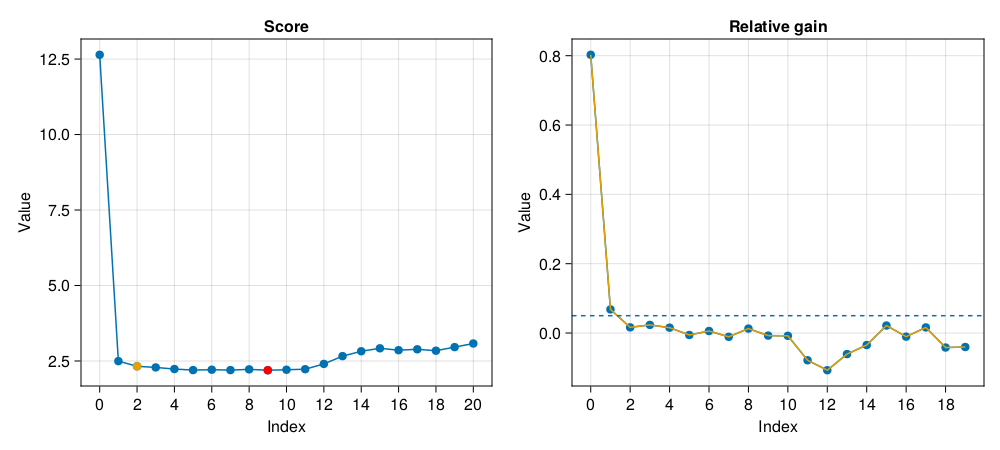

In [27]:
res_sel.f       # plots

In [28]:
res_sel.opt     # nb. LVs correponding to the minimal error rate

9

In [29]:
res_sel.sel     # nb. LVs selected with the Wold's criterion

2

In [30]:
# Final prediction with the parcimonious model
fm = plskern(Xtrain, ytrain; nlv = res_sel.sel) ;
pred = Jchemo.predict(fm, Xtest).pred
rmsep(pred, ytest)

1×1 Matrix{Float64}:
 2.216302250167832

In [31]:
# !!! Remark
# Function "gridcv" is generic for all the functions.
# Here, it could be used instead of "gridcvlv"
# but this is not time-efficient for LV-based methods.
# Commands below return the same results as
# with 'gridcvlv', but in a slower way
nlv = 0:20
pars = mpar(nlv = nlv)
res = gridcv(Xtrain, ytrain; segm = segm,
    score = rmsep, fun = plskern, pars = pars,
    verbose = false).res
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,nlv,y1
,Int64,Float64
10,9,2.19391


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*